## Hedging using Machine Learning Techniques

### Summary

As systematic and macro factors dominate the investment landscape, we see equity investors move away from one-size-fits all hedging strategies to more precise ways to separate intended and unintended risks and isolate alpha. 

If you are a fundamental equity investor, take concentrated positions in single names, or have significant idiosyncratic risk that is otherwise difficult to hedge, this highly customizable correlation-based approach is for you. Traditional factor based hedges can fare poorly when most of the risk cannot be explained by factors – in those instances this approach can allow for much better correlation to offset risk as well as a number of ways to guide which names get included while ensuring a high level of tradability by controlling liquidity and borrow costs.

In this notebook, we will showcase how to leverage this approach through one of our most popular tools, the [marquee performance hedger](https://marquee.gs.com/s/hedging/performance).

Additionally, based on feedback we have received from top users, we are adding the ability to easily run and compare hedges in python through [gs quant](https://developer.gs.com/docs/gsquant/) as well as new modeling techniques, two of whose key advantages are:

* **Increased accuracy** through reduced overfitting
* **More control** by allowing the user to specify how concentrated or diversified the hedge portfolio is


The contents of this notebook are as follows:
* [1 - Let's get started with gs quant](#1---Let's-get-started-with-gs-quant)
* [2 - Calculate a hedge](#2---Calculate-a-hedge)
* [3 - Increased accuracy](#3---Increased-accuracy)
* [4 - More control](#4---More-control)
* [5 - Customizing your optimization](#5---Customizing-your-optimization)

### 1 - Let's get started with gs quant
Start every session with authenticating with your unique client id and secret. If you don't have a registered app, create one [here](https://marquee.gs.com/s/developer/myapps/register). `run_analytics` scope is required for the functionality covered in this example.

In [1]:
from gs_quant.session import GsSession, Environment
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics',))

Below, you can set the logging level of the notebook. By default, we set the level to INFO to show informative statements about the hedging functions.

In [2]:
import logging

logging.basicConfig(level=logging.INFO)

### 2 - Calculate a Hedge

Let's start by calculating a hedge for Amazon with some starting parameters.

To leverage the (machine learning-based) techniques in the enhanced performance hedger, please ensure:
* `use_machine_learning` parameter is true

Note: the hedge result utilizes optimal values found (using grid search) for the ML parameters, which are known as Concentration (`lasso_weight`) and Diversity (`ridge_weight`)

In [3]:
from gs_quant.api.gs.hedges import GsHedgeApi
from gs_quant.markets.securities import SecurityMaster, AssetIdentifier
from datetime import date
import pandas as pd

target_asset = SecurityMaster.get_asset('AMZN UW', AssetIdentifier.BLOOMBERG_ID).get_marquee_id()
universe = SecurityMaster.get_asset('SPX', AssetIdentifier.BLOOMBERG_ID).get_marquee_id()
hedge_query_example = GsHedgeApi.construct_performance_hedge_query(hedge_target=target_asset, 
                                                                   universe=(universe, ),
                                                                   notional=10e6,
                                                                   observation_start_date=date(2019, 3, 25), 
                                                                   observation_end_date=date(2020, 3, 24), 
                                                                   backtest_start_date=date(2020, 3, 25), 
                                                                   backtest_end_date=date(2020, 4, 24),
                                                                   use_machine_learning=True)

# Calculate the hedge using the hedge_query_example as input
results = GsHedgeApi.calculate_hedge(hedge_query_example)
pd.DataFrame(results['result']['hedgedTarget']['constituents']).head(3)

,country,name,transactionCost,sector,shares,assetId,bbid,currency,industry,marginalCost,advPercentage,price,weight,borrowCost
0,United States,Adobe Inc,20.263329,Information Technology,-832.032329,MA4B66MW5E27U9XPV7X,ADBE UW,USD,Software,0.261326,0.000149,310.00,-0.012897,40
1,United States,Autodesk Inc,20.628566,Information Technology,-1387.449548,MA4B66MW5E27U9XPVBT,ADSK UW,USD,Software,0.214601,0.000393,149.96,-0.010403,40
2,United States,Akamai Technologies Inc,26.810420,Information Technology,-4678.311848,MA4B66MW5E27U9XPVVM,AKAM UW,USD,IT Services,0.564298,0.002052,89.98,-0.021048,40


### 3 - Increased Accuracy

Now let's compare results with and without using the new machine learning parameters and examine the first advantage - improved accuracy.

We can do this by looking at the out-of-sample differences in cumulative returns of the two hedges over a hedge backtest period. Note here that we fit the hedge to the observation window and use the backtest window to see how both hedges perform. 

Note for this example: the ML parameters, Concentration (lasso_weight) and Diversity (ridge_weight), are being manually passed in, which is an alternative way to run the new performance hedger (compared to running grid search to find the optimal pair)

In [4]:
observation_start = date(2019, 3, 25)
observation_end = date(2020, 3, 24)
backtest_start = observation_end
backtest_end = date(2020, 4, 24)

standard_hedger_query = GsHedgeApi.construct_performance_hedge_query(hedge_target=target_asset, 
                                                                     universe=(universe, ), 
                                                                     notional=10e6,
                                                                     observation_start_date=observation_start, 
                                                                     observation_end_date=observation_end, 
                                                                     backtest_start_date=backtest_start, 
                                                                     backtest_end_date=backtest_end,
                                                                     max_return_deviation=20)

new_hedger_query = GsHedgeApi.construct_performance_hedge_query(hedge_target=target_asset, 
                                                                universe=(universe, ), 
                                                                notional=10e6,
                                                                observation_start_date=observation_start,
                                                                observation_end_date=observation_end,
                                                                backtest_start_date=backtest_start,
                                                                backtest_end_date=backtest_end,
                                                                use_machine_learning=True,
                                                                lasso_weight=5.0,
                                                                ridge_weight=5.0,
                                                                max_return_deviation=20)

standard_results = GsHedgeApi.calculate_hedge(standard_hedger_query)
new_hedger_results = GsHedgeApi.calculate_hedge(new_hedger_query)

In [5]:
import matplotlib.pyplot as plt
def compare_backtests_against_target_asset(new_results, standard_results, figsize=(10, 6)):
    dates, target_returns = zip(*new_results['result']['target']['backtestPerformance'])
    _, new_hedge_returns = zip(*new_results['result']['hedge']['backtestPerformance'])
    _, standard_hedge_returns = zip(*standard_results['result']['hedge']['backtestPerformance'])
    
    results = pd.DataFrame([pd.Series(target_returns, dates, name='Target'), 
                           pd.Series(new_hedge_returns, dates, name='New Hedger'),
                           pd.Series(standard_hedge_returns, dates, name='Standard Hedger')]).T
    
    results.plot(figsize=(10, 6))
    plt.legend(fontsize=18)
    plt.xlabel('Backtest Period', size=13)
    plt.ylabel('Cumulative Returns (% change)', size=13)
    plt.title('Hedge Performance Against Asset', size=22)

Now, we plot the cumulative returns of the target asset against the cumulative returns of each hedge.

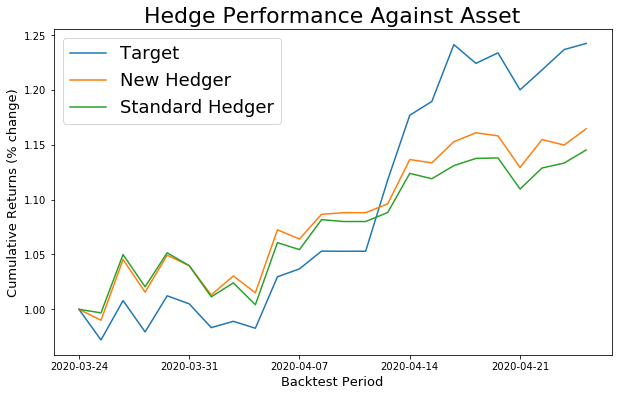

In [6]:
compare_backtests_against_target_asset(new_hedger_results, standard_results)

As you can see above, the New Performance Hedger more closely tracks the target asset in the backtest, or "simulated future", period (and thus is more accurate).

### 4 - More Control

Now, let's demonstrate the second advantage, namely the enhanced control we have over the performance hedger results.

Below, you can plot the effects of varying Concentration and Diversity on your hedge query from section 2 above. 

In this example, if the values for Concentration are 'None' and the values for Diversity are [10, 20], then the plotting function would run the hedge query passed in for Diversity values of 10% and 20% and then plot the weight/number of asset distributions on the y-axis and x-axis, respectively. 


In [7]:
# For now, use ONLY Concentration or Diversity when plotting to view the effects of this hyperparameter value changing on a hedge (set the hyperparam you aren't 
# using to None)
hyperparams = {'Concentration': None, 'Diversity': [10, 20]}

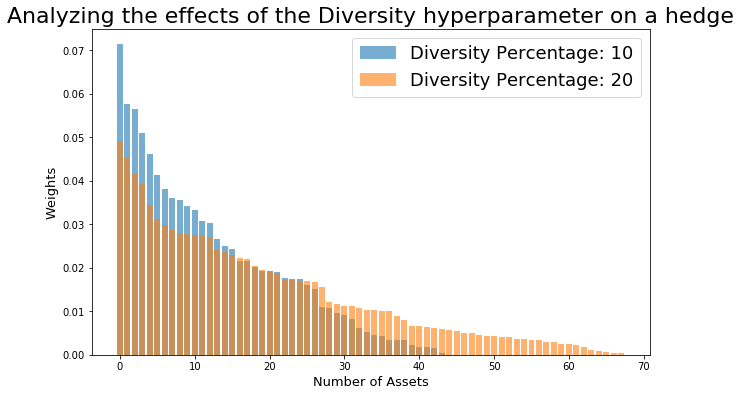

In [8]:
from gs_quant.markets.hedge import Hedge

# Plot results of the hedge - with emphasis on the effects that either the Concentration or Diversity hyperparameter has on the hedge
hedge_plot = Hedge.plot_weights_against_number_of_assets(hedge_query_example, hyperparams, figsize=(10, 6))

As you can see above, varying the value of a single hyperparameter has significant effects on the weights & total number of assets of the hedge portfolio that is constructed to hedge the single target asset.

For this particular example, the effect is that the weights become more balanced the more the "Diversity" hyperparameter increases.

### 5 - Customizing your Optimization

Since we know how to run a basic hedge, let's experiment with the concentration and diversity metrics to find an optimal hedge.

Note, the hedger is flexible and allows you to choose which metric to optimize - for example, you may want to run to optimize correlation (in which case you would maximize r-squared) or to optimize transaction costs (in which case you would minimize total transaction costs).

In [9]:
# Modify hyperparameter grid to the values you want to use to find the optimal hedge . As mentioned before, the terminology used for Concentration and Diversity
# seen below relates to the terminology used for each term in the machine learning literature.
# Concentration = Lasso (as a percentage)
# Diversity = Ridge (as a percentage)
hyperparams = {'Concentration': [0, 20, 40], 'Diversity': [10, 20]}

# Modify this to optimize a metric (maximize or minimize depending on the metric. 
# See the create_optimization_mappings function for how metrics are optimized
metric_to_optimize = 'rSquared'

Let's now run the optimization through the custom grid of concentration/diversity values we specified, and optimize for the specified metric. In this case, we will look for the combination of concentration and diversity values that maximizes correlation, or r-squared.

In [10]:
from gs_quant.markets.hedge import Hedge

opt_hedge, opt_metric_val, opt_hyperparams = Hedge.find_optimal_hedge(hedge_query_example, hyperparams, metric_to_optimize)
print(f'The optimal pair of hyperparameters was {opt_hyperparams}, achieving a value for {metric_to_optimize} '
                     f'of {opt_metric_val*100:.3}% during the out of sample period.')

INFO:gs_quant.markets.hedge:We are trying to maximize rSquared and will return the optimized hedge & metric value...
INFO:gs_quant.markets.hedge:Current Hedge is using the following values for Concentration/Diversity: (0, 10)
INFO:gs_quant.markets.hedge:Current Hedge value for rSquared: 67.6%
INFO:gs_quant.markets.hedge:Current Hedge is using the following values for Concentration/Diversity: (0, 20)
INFO:gs_quant.markets.hedge:Current Hedge value for rSquared: 65.3%
INFO:gs_quant.markets.hedge:Current Hedge is using the following values for Concentration/Diversity: (20, 10)
INFO:gs_quant.markets.hedge:Current Hedge value for rSquared: 65.6%
INFO:gs_quant.markets.hedge:Current Hedge is using the following values for Concentration/Diversity: (20, 20)
INFO:gs_quant.markets.hedge:Current Hedge value for rSquared: 63.4%
INFO:gs_quant.markets.hedge:Current Hedge is using the following values for Concentration/Diversity: (40, 10)
INFO:gs_quant.markets.hedge:Current Hedge value for rSquared: 6

The optimal pair of hyperparameters was (0, 10), achieving a value for rSquared of 67.6% during the out of sample period.


Stay tuned for additional ways to use the New Performance Hedger using `gs-quant`. For any questions/comments, feel free to reach out to the email distro **gs-data-ml**!